In [96]:
import pandas as pd
import numpy as np
from pathlib import Path

def tabularize_fuel_oil_no2_pricing(pricing_source_file, output_file, years_to_average, cost_col, output_cost_column):
    fuel_oil_no2_pricing = pd.read_csv(pricing_source_file)
    fuel_oil_no2_pricing.fillna(0)
    fuel_oil_no2_pricing["Year"] = pd.to_datetime(fuel_oil_no2_pricing['Week of']).dt.year
    fuel_oil_no2_pricing["Month"] = pd.to_datetime(fuel_oil_no2_pricing['Week of']).dt.month
    fuel_oil_no2_pricing = fuel_oil_no2_pricing[ fuel_oil_no2_pricing["Year"].isin(years_to_average) ]

    output_fuel_oil_no2_pricing = []
    for month in fuel_oil_no2_pricing["Month"].unique(): 
        data = fuel_oil_no2_pricing[ fuel_oil_no2_pricing["Month"] == month ]
        output_fuel_oil_no2_pricing.append({'Month': month, output_cost_column: data[cost_col].mean()})
    
    output_fuel_oil_no2_pricing = pd.DataFrame(output_fuel_oil_no2_pricing)
    output_fuel_oil_no2_pricing = output_fuel_oil_no2_pricing.sort_values(by=['Month'])
    output_fuel_oil_no2_pricing.to_csv(output_file, index=False)

    return None

    
def tabularize_monthly_state_specific_pricing(input_pricing_file, output_pricing_file, cost_column):
    """ 
    Convert from a table with different columns for each state's price, to rows where each row is a month of a state and its price. 
    """

    pricing = pd.read_csv(input_pricing_file)
    # set the column names for the natural gas 
    national_and_cities_columns = set(pricing.columns) - set("Date")  
    dataframes_list = []
    for column in national_and_cities_columns: 
        for state in us_state_to_abbrev.keys():
            if state in column: 
                # print(f"state: {state} column: {column}")
                temp_df = pd.DataFrame()
                temp_df["Month"] = pricing["Month"].to_list()
                temp_df["State"] = us_state_to_abbrev.get(state)
                temp_df[cost_column] = pricing[state].to_list()
                dataframes_list.append(temp_df)
                del temp_df

    pricing = pd.concat(dataframes_list)
    pricing.to_csv(output_pricing_file, index=False)
    
    return None


def average_pricing_by_states(pricing_source_file, years_to_average, exclude_cols_from_average):
    pricing = pd.read_csv(pricing_source_file)
    pricing.fillna(0)
    pricing = pricing[ pricing["Year"].isin(years_to_average) ]

    cols_to_average = list(set(pricing.columns) - set(exclude_cols_from_average))
    
    dataframes_list = []
    for month in pricing["Month"].unique(): 
        data = pricing[ pricing["Month"] == month ]
        data = {col: [data[col].mean()] for col in cols_to_average}   # List comprehension way to build a dictionary of the month's average price for each column to average 
        data = {**{"Month": month}, **data}                         # Add the month to the front of the dictionary
        dataframes_list.append(pd.DataFrame(data))
        del data

    pricing = pd.concat(dataframes_list)
    pricing = pricing.sort_values(by=['Month'])

    return pricing


def linearly_interpolate_pricing(xa, xb, month_col, pricing):
    pricing_array = pricing.to_numpy()

    m = (pricing_array[pricing_array[:,month_col] == xb] - pricing_array[pricing_array[:,month_col] == xa]) 
    m = m / m[month_col][month_col]

    b = m*(-xa) + pricing_array[pricing_array[:,month_col] == xa]

    for x in range(xa+1, xb):
        y = np.zeros(np.shape(m))
        y = m*x + b 
        pricing_array = np.vstack([pricing_array, y])

    pricing = pd.DataFrame(pricing_array, columns = pricing.columns)
    pricing["Month"] = pricing["Month"].astype(int)
    pricing = pricing.sort_values(by=['Month'])
    return pricing


us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

# Natural Gas

In [97]:
nat_gas_pricing_source_file = Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Natural gas/NG_PRI_SUM_A_EPG0_PRS_DMCF_M By (Month).csv")
nat_gas_pricing_output_table_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data", "natural_gas_pricing.csv")

####### (If not done yet) Convert source pricing table (with some minor excel modifications) to table for merging on results ###############
new_cost_column_name = 'Price of Natural Gas Delivered to Residential Consumers (Dollars per Thousand Cubic Feet)'
tabularize_monthly_state_specific_pricing(nat_gas_pricing_source_file, nat_gas_pricing_output_table_file, new_cost_column_name)     


# Fuel Oil

In [98]:
fuel_oil_no2_pricing_source_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Weekly_U.S._Weekly_No._2_Heating_Oil_Residential_Price_clean header.csv")
fuel_oil_no2_pricing_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Monthly_No._2_Heating_Oil_Residential_Price.csv") 

###### (If not done yet) Convert source pricing table (with some minor excel modifications) to table for merging on results ###############
years_to_average = range(2019, 2020 +1)
cost_col = "Weekly U.S. Weekly No. 2 Heating Oil Residential Price Dollars per Gallon"
output_cost_column = 'Monthly No. 2 Heating Oil Residential Price Dollars per Gallon'
tabularize_fuel_oil_no2_pricing(fuel_oil_no2_pricing_source_file, fuel_oil_no2_pricing_file, years_to_average, cost_col, output_cost_column)

## If you've just created the table for the first time, linearly interpolate the missing data 
## You might be able to use the function i created for linearly interpolating. For the current data which is just for the whole US (12 data points), I did the interpolationg in excel


/var/folders/_y/4mxb3fn133zdycdh3jhdzvc00000gn/T/ipykernel_8318/4214663511.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fuel_oil_no2_pricing["Year"] = pd.to_datetime(fuel_oil_no2_pricing['Week of']).dt.year
/var/folders/_y/4mxb3fn133zdycdh3jhdzvc00000gn/T/ipykernel_8318/4214663511.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fuel_oil_no2_pricing["Month"] = pd.to_datetime(fuel_oil_no2_pricing['Week of']).dt.month


# Propane
## First Average the pricing data to the monthly level from weekly level 

In [99]:
pricing_source_file = Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Propane/weekly_USA/weekly_propane_pricing_USA.csv")
average_propane_pricing_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Monthly_Propane_Price.csv") 

columns_to_exclude_from_averaging = ["Date",	"Month",	"Year"]

# average_pricing_by_states(columns_to_exclude_from_averaging)
years_to_average = range(2019, 2020 +1)
average_propane_pricing_by_states = average_pricing_by_states(pricing_source_file, years_to_average, columns_to_exclude_from_averaging)
average_propane_pricing_by_states.to_csv(average_propane_pricing_file, index=False)
average_propane_pricing_by_states

,Month,Mississippi,Ohio,Wisconsin,U.S.,North Carolina,Alabama,Kansas,Missouri,Illinois,...,New York,Rocky Mountain (PADD 4),Colorado,New England (PADD 1A),Georgia,Michigan,Delaware,Midwest (PADD 2),Gulf Coast (PADD 3),Central Atlantic (PADD 1B)
0,1,2.420875,2.377375,1.562125,2.216000,2.726375,2.473000,1.442750,1.682250,1.630000,...,2.910125,1.979625,1.943625,2.958125,2.274750,1.881125,2.884875,1.727250,2.318625,2.839250
0,2,2.432375,2.379125,1.550375,2.207125,2.703750,2.482375,1.442250,1.671125,1.587250,...,2.918875,1.966750,1.931500,2.948625,2.317000,1.879375,2.885000,1.714000,2.319875,2.841375
0,3,2.414778,2.289000,1.487778,2.141111,2.645556,2.418556,1.414000,1.609444,1.535111,...,2.861778,1.906556,1.856444,2.901667,2.267000,1.828333,2.847444,1.649556,2.269333,2.790444
0,10,2.221500,1.840125,1.249500,1.813875,2.514000,2.203250,1.224250,1.370125,1.320375,...,2.410500,1.528125,1.564875,2.669875,2.184625,1.576125,2.552250,1.398500,2.033125,2.383625
0,11,2.260111,1.924333,1.375778,1.891778,2.534556,2.255667,1.276000,1.453889,1.494778,...,2.440778,1.621333,1.649889,2.691889,2.233444,1.642222,2.551778,1.515111,2.087333,2.403000
0,12,2.302222,2.041111,1.486667,1.977889,2.600222,2.349778,1.336556,1.532222,1.600667,...,2.536111,1.718444,1.750111,2.778000,2.282889,1.724111,2.600000,1.607000,2.154000,2.488222


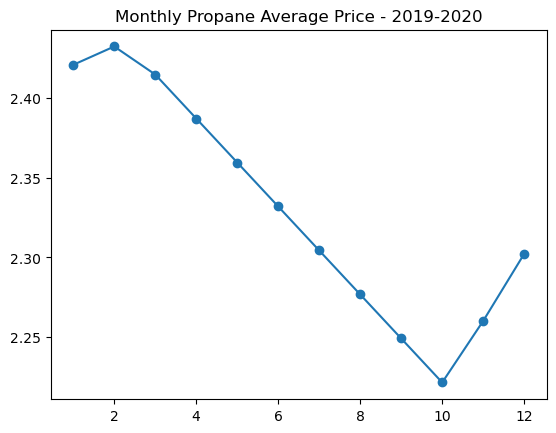

In [100]:
average_propane_pricing_by_states = pd.read_csv(average_propane_pricing_file)
interpolated_propane_pricing_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Monthly_Propane_Price_Interpolated.csv") 

# xa and xb chosen as Months on either side of the missing months section
xa = 3
xb = 10    
month_col = 0

interpolated_average_propane_pricing_by_states = linearly_interpolate_pricing(xa, xb, month_col, average_propane_pricing_by_states)

import matplotlib.pyplot as plt
plt.plot(interpolated_average_propane_pricing_by_states.iloc[:,0], interpolated_average_propane_pricing_by_states.iloc[:,1], marker='o')
plt.title(f"Monthly Propane Average Price - {years_to_average[0]}-{years_to_average[-1]}")

interpolated_average_propane_pricing_by_states.to_csv(interpolated_propane_pricing_file, index=False)

### Now tabularize the data 
Convert from a table with different columns for each state's price, to rows where each row is a month of a state and its price. 

In [101]:
interpolated_propane_pricing_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Monthly_Propane_Price_Interpolated.csv") 
new_cost_column_name = 'Monthly U.S. Propane Residential Price (Dollars per Gallon)'
tabularize_monthly_state_specific_pricing(interpolated_propane_pricing_file, interpolated_propane_pricing_file, new_cost_column_name)